# 🏥 Ontario ED Intelligence — Notebook 03
## Module 3: ALC Bed Block Analyzer

**Goal:** Identify patients at risk of becoming ALC (Alternate Level of Care) at admission.

**ALC = patients occupying acute beds while waiting for:**
- Long-Term Care (LTC) placement
- Home care services
- Rehabilitation facility

**Why this matters:** Ontario hospitals report 15-25% of acute beds blocked by ALC patients.
At Sunnybrook alone, that can mean 80-100 beds unavailable on any given day.

**Model:** XGBoost classifier + SHAP explainability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import warnings
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, average_precision_score
)

warnings.filterwarnings('ignore')
np.random.seed(42)

print('✅ Libraries loaded')
print(f'   xgboost : {xgb.__version__}')
print(f'   shap    : {shap.__version__}')

✅ Libraries loaded
   xgboost : 3.2.0
   shap    : 0.50.0


## 1️⃣ Generate Realistic Patient Admission Data

In [2]:
N = 8000

age = np.random.choice(
    range(18, 100), size=N,
    p=np.array([0.5 if a < 65 else 2.5 if a < 75 else 5.0 if a < 85 else 6.0
                for a in range(18, 100)], dtype=float) /
      sum([0.5 if a < 65 else 2.5 if a < 75 else 5.0 if a < 85 else 6.0
           for a in range(18, 100)])
)

sex = np.random.choice(['M', 'F'], size=N, p=[0.47, 0.53])

diagnosis = np.random.choice(
    ['Hip Fracture', 'Stroke', 'Dementia', 'COPD', 'CHF',
     'Pneumonia', 'UTI', 'Sepsis', 'Elective Surgery', 'Other'],
    size=N,
    p=[0.10, 0.10, 0.12, 0.10, 0.08, 0.10, 0.08, 0.07, 0.12, 0.13]
)

hospital = np.random.choice(
    ['Sunnybrook HSC', 'Unity Health', 'North York General',
     'Scarborough Health Network', 'Humber River Health', 'Trillium Health Partners'],
    size=N
)

lives_alone      = np.random.binomial(1, np.clip(0.35 + 0.003 * (age - 18), 0, 1))
has_caregiver    = np.random.binomial(1, np.clip(0.60 - 0.003 * (age - 18), 0, 1))
prior_admissions = np.random.poisson(1.5, N).clip(0, 10)
ed_visits_6m     = np.random.poisson(1.2, N).clip(0, 8)
ambulatory_pre   = np.random.binomial(1, np.clip(0.75 - 0.004 * (age - 18), 0, 1))
cognitive_impair = np.random.binomial(1, np.clip(0.05 + 0.008 * (age - 18), 0, 1))
functional_score = (100 - age * 0.6 + np.random.normal(0, 15, N)).clip(0, 100).round(1)
charlson_index   = np.random.choice(range(0, 12), size=N,
                                     p=[0.20,0.18,0.15,0.12,0.10,0.08,0.06,0.04,0.03,0.02,0.01,0.01])
los_days         = np.random.lognormal(mean=1.8, sigma=0.8, size=N).clip(1, 120).round().astype(int)

alc_prob = (
    0.02
    + 0.008  * (age - 18)
    + 0.25   * (diagnosis == 'Dementia').astype(float)
    + 0.20   * (diagnosis == 'Stroke').astype(float)
    + 0.18   * (diagnosis == 'Hip Fracture').astype(float)
    + 0.10   * lives_alone
    + 0.15   * cognitive_impair
    - 0.12   * has_caregiver
    + 0.008  * charlson_index
    - 0.001  * functional_score
    + 0.010  * los_days
    + 0.03   * prior_admissions
    + np.random.normal(0, 0.08, N)
).clip(0, 1)

alc_flag = (alc_prob > 0.45).astype(int)

df = pd.DataFrame({
    'age': age, 'sex': sex, 'diagnosis': diagnosis, 'hospital': hospital,
    'lives_alone': lives_alone, 'has_caregiver': has_caregiver,
    'prior_admissions': prior_admissions, 'ed_visits_6m': ed_visits_6m,
    'ambulatory_pre_admit': ambulatory_pre, 'cognitive_impairment': cognitive_impair,
    'functional_score': functional_score, 'charlson_index': charlson_index,
    'los_days': los_days, 'alc_flag': alc_flag
})

print(f'✅ Patient dataset generated')
print(f'   Total patients : {len(df):,}')
print(f'   ALC patients   : {df.alc_flag.sum():,} ({df.alc_flag.mean()*100:.1f}%)')
print(f'   Avg age        : {df.age.mean():.1f} years')
print(f'   Avg LOS        : {df.los_days.mean():.1f} days')
df.head()

✅ Patient dataset generated
   Total patients : 8,000
   ALC patients   : 7,048 (88.1%)
   Avg age        : 79.0 years
   Avg LOS        : 8.1 days


,age,sex,diagnosis,hospital,lives_alone,has_caregiver,prior_admissions,ed_visits_6m,ambulatory_pre_admit,cognitive_impairment,functional_score,charlson_index,los_days,alc_flag
0,79,F,Hip Fracture,Unity Health,1,1,0,3,1,1,63.9,0,3,1
1,98,F,Hip Fracture,Scarborough Health Network,1,1,2,1,0,1,50.7,2,2,1
2,91,M,CHF,Unity Health,0,1,1,1,0,1,71.9,1,9,1
3,87,F,Hip Fracture,Scarborough Health Network,0,1,1,1,0,1,83.3,1,12,1
4,67,F,Other,Unity Health,1,1,2,2,1,1,52.2,2,10,1


## 2️⃣ ALC Distribution by Hospital & Diagnosis

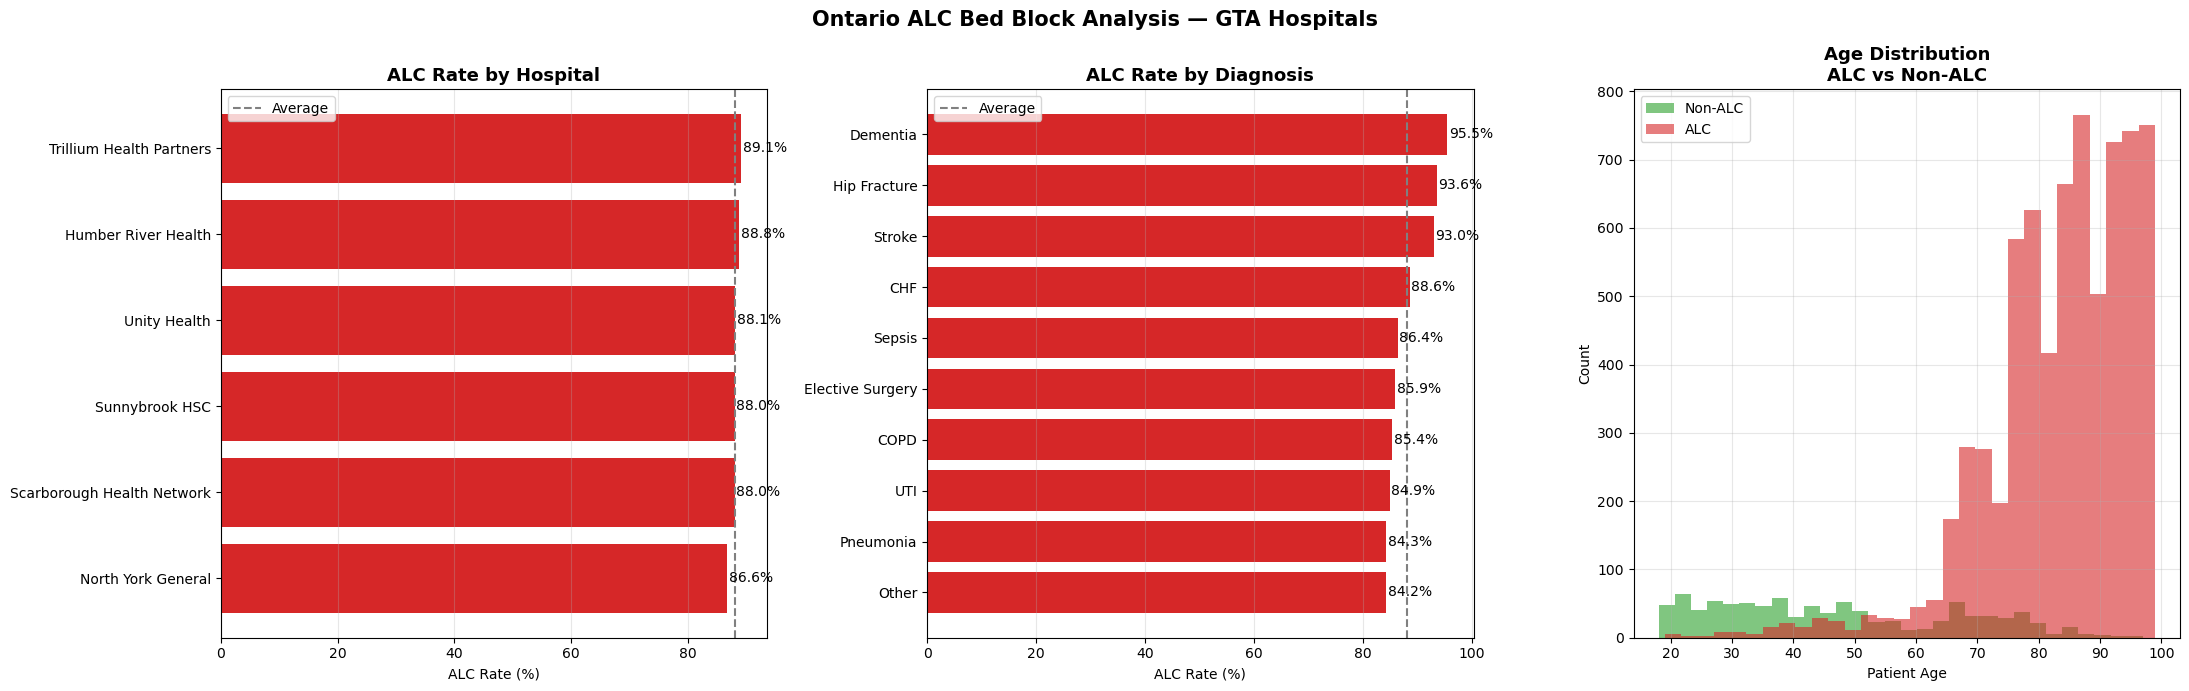

✅ Saved → reports/alc_distribution.png


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

hosp_alc = df.groupby('hospital')['alc_flag'].mean().sort_values(ascending=True) * 100
colours_hosp = ['#d62728' if v > 20 else '#ff7f0e' if v > 15 else '#2ca02c' for v in hosp_alc.values]
bars = axes[0].barh(hosp_alc.index, hosp_alc.values, color=colours_hosp)
axes[0].set_xlabel('ALC Rate (%)')
axes[0].set_title('ALC Rate by Hospital', fontsize=13, fontweight='bold')
axes[0].axvline(x=hosp_alc.mean(), color='grey', linestyle='--', label='Average')
axes[0].legend()
for bar, val in zip(bars, hosp_alc.values):
    axes[0].text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='x')

diag_alc = df.groupby('diagnosis')['alc_flag'].mean().sort_values(ascending=True) * 100
colours_diag = ['#d62728' if v > 25 else '#ff7f0e' if v > 15 else '#2ca02c' for v in diag_alc.values]
bars2 = axes[1].barh(diag_alc.index, diag_alc.values, color=colours_diag)
axes[1].set_xlabel('ALC Rate (%)')
axes[1].set_title('ALC Rate by Diagnosis', fontsize=13, fontweight='bold')
axes[1].axvline(x=diag_alc.mean(), color='grey', linestyle='--', label='Average')
axes[1].legend()
for bar, val in zip(bars2, diag_alc.values):
    axes[1].text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

df[df['alc_flag']==0]['age'].hist(ax=axes[2], bins=30, alpha=0.6, color='#2ca02c', label='Non-ALC')
df[df['alc_flag']==1]['age'].hist(ax=axes[2], bins=30, alpha=0.6, color='#d62728', label='ALC')
axes[2].set_xlabel('Patient Age')
axes[2].set_ylabel('Count')
axes[2].set_title('Age Distribution\nALC vs Non-ALC', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Ontario ALC Bed Block Analysis — GTA Hospitals', fontsize=15, fontweight='bold')
plt.tight_layout()
os.makedirs('../reports', exist_ok=True)
plt.savefig('../reports/alc_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved → reports/alc_distribution.png')

## 3️⃣ Train XGBoost Classifier

In [4]:
df_model = df.copy()
le_sex  = LabelEncoder()
le_diag = LabelEncoder()
le_hosp = LabelEncoder()

df_model['sex_enc']       = le_sex.fit_transform(df_model['sex'])
df_model['diagnosis_enc'] = le_diag.fit_transform(df_model['diagnosis'])
df_model['hospital_enc']  = le_hosp.fit_transform(df_model['hospital'])

feature_cols = [
    'age', 'sex_enc', 'diagnosis_enc', 'hospital_enc',
    'lives_alone', 'has_caregiver', 'prior_admissions',
    'ed_visits_6m', 'ambulatory_pre_admit', 'cognitive_impairment',
    'functional_score', 'charlson_index', 'los_days'
]

feature_names_display = [
    'Age', 'Sex', 'Diagnosis', 'Hospital',
    'Lives Alone', 'Has Caregiver', 'Prior Admissions',
    'ED Visits (6mo)', 'Ambulatory Pre-Admit', 'Cognitive Impairment',
    'Functional Score', 'Charlson Index', 'Length of Stay'
]

X = df_model[feature_cols]
y = df_model['alc_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y==0).sum()/(y==1).sum(),
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred      = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]
auc         = roc_auc_score(y_test, y_pred_prob)
ap          = average_precision_score(y_test, y_pred_prob)

print(f'✅ XGBoost model trained')
print(f'   ROC-AUC       : {auc:.4f}')
print(f'   Avg Precision : {ap:.4f}')
print()
print(classification_report(y_test, y_pred, target_names=['Non-ALC', 'ALC']))

✅ XGBoost model trained
   ROC-AUC       : 0.9840
   Avg Precision : 0.9978

              precision    recall  f1-score   support

     Non-ALC       0.72      0.91      0.81       190
         ALC       0.99      0.95      0.97      1410

    accuracy                           0.95      1600
   macro avg       0.86      0.93      0.89      1600
weighted avg       0.96      0.95      0.95      1600



## 4️⃣ Model Performance Plots

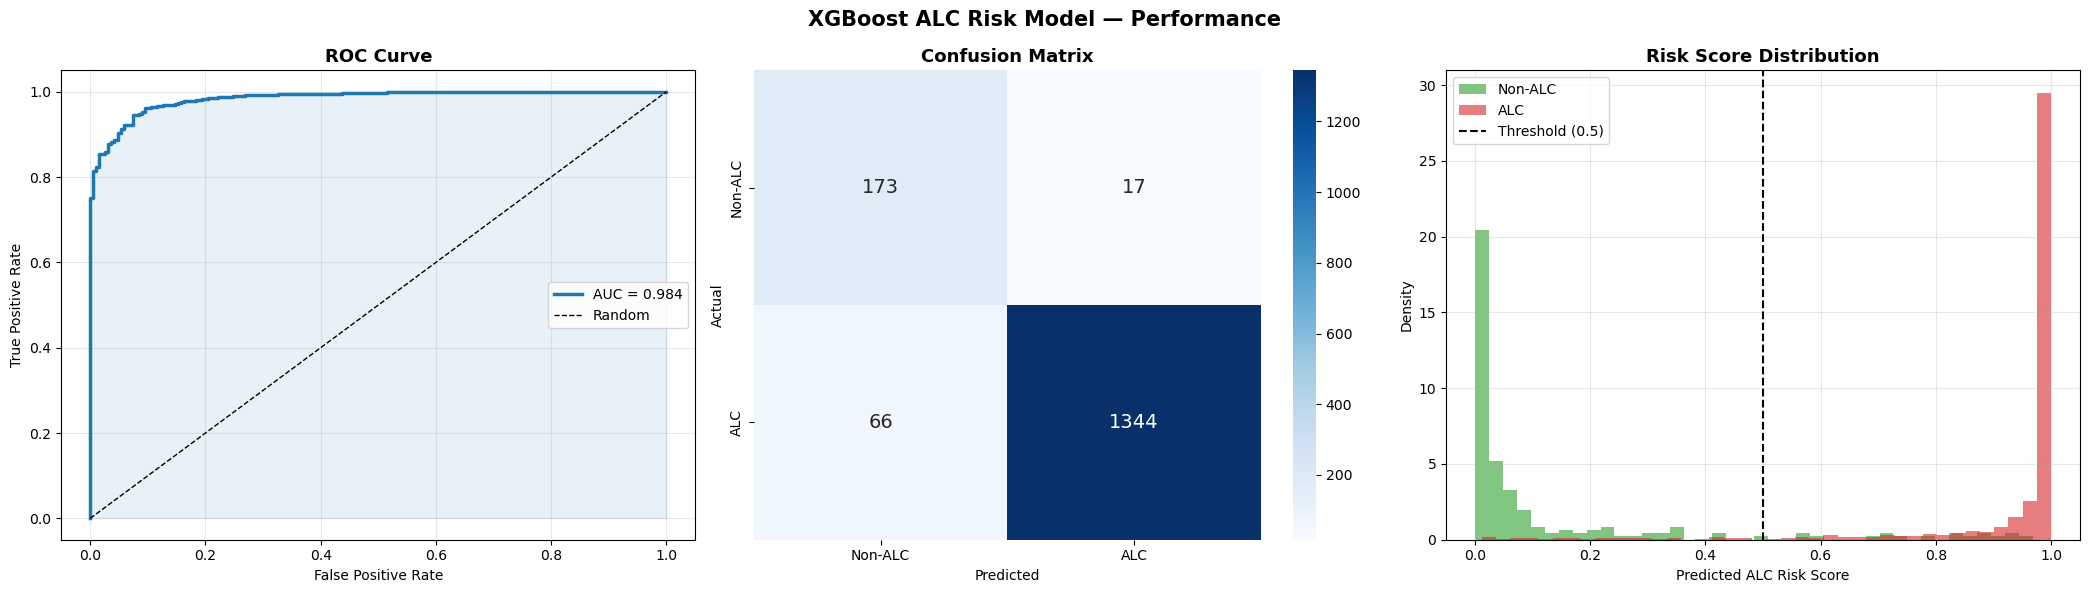

✅ Saved → reports/alc_model_performance.png


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[0].plot(fpr, tpr, color='#1f77b4', lw=2.5, label=f'AUC = {auc:.3f}')
axes[0].plot([0,1],[0,1], 'k--', lw=1, label='Random')
axes[0].fill_between(fpr, tpr, alpha=0.1, color='#1f77b4')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Non-ALC','ALC'], yticklabels=['Non-ALC','ALC'],
            annot_kws={'size': 14})
axes[1].set_title('Confusion Matrix', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

axes[2].hist(y_pred_prob[y_test==0], bins=40, alpha=0.6, color='#2ca02c', label='Non-ALC', density=True)
axes[2].hist(y_pred_prob[y_test==1], bins=40, alpha=0.6, color='#d62728', label='ALC', density=True)
axes[2].axvline(x=0.5, color='black', linestyle='--', linewidth=1.5, label='Threshold (0.5)')
axes[2].set_xlabel('Predicted ALC Risk Score')
axes[2].set_ylabel('Density')
axes[2].set_title('Risk Score Distribution', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('XGBoost ALC Risk Model — Performance', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/alc_model_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved → reports/alc_model_performance.png')

## 5️⃣ SHAP Explainability

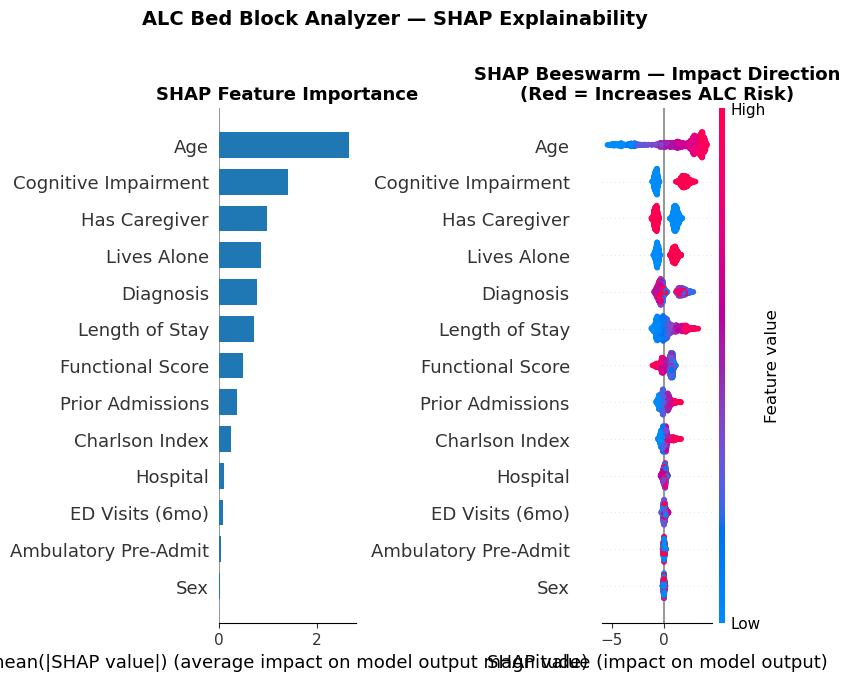

✅ Saved → reports/alc_shap_explainability.png


In [6]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

plt.sca(axes[0])
shap.summary_plot(shap_values, X_test, feature_names=feature_names_display,
                  plot_type='bar', show=False, color='#1f77b4')
axes[0].set_title('SHAP Feature Importance', fontsize=13, fontweight='bold')

plt.sca(axes[1])
shap.summary_plot(shap_values, X_test, feature_names=feature_names_display, show=False)
axes[1].set_title('SHAP Beeswarm — Impact Direction\n(Red = Increases ALC Risk)',
                   fontsize=13, fontweight='bold')

plt.suptitle('ALC Bed Block Analyzer — SHAP Explainability', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../reports/alc_shap_explainability.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved → reports/alc_shap_explainability.png')

## 6️⃣ Beds Blocked Dashboard

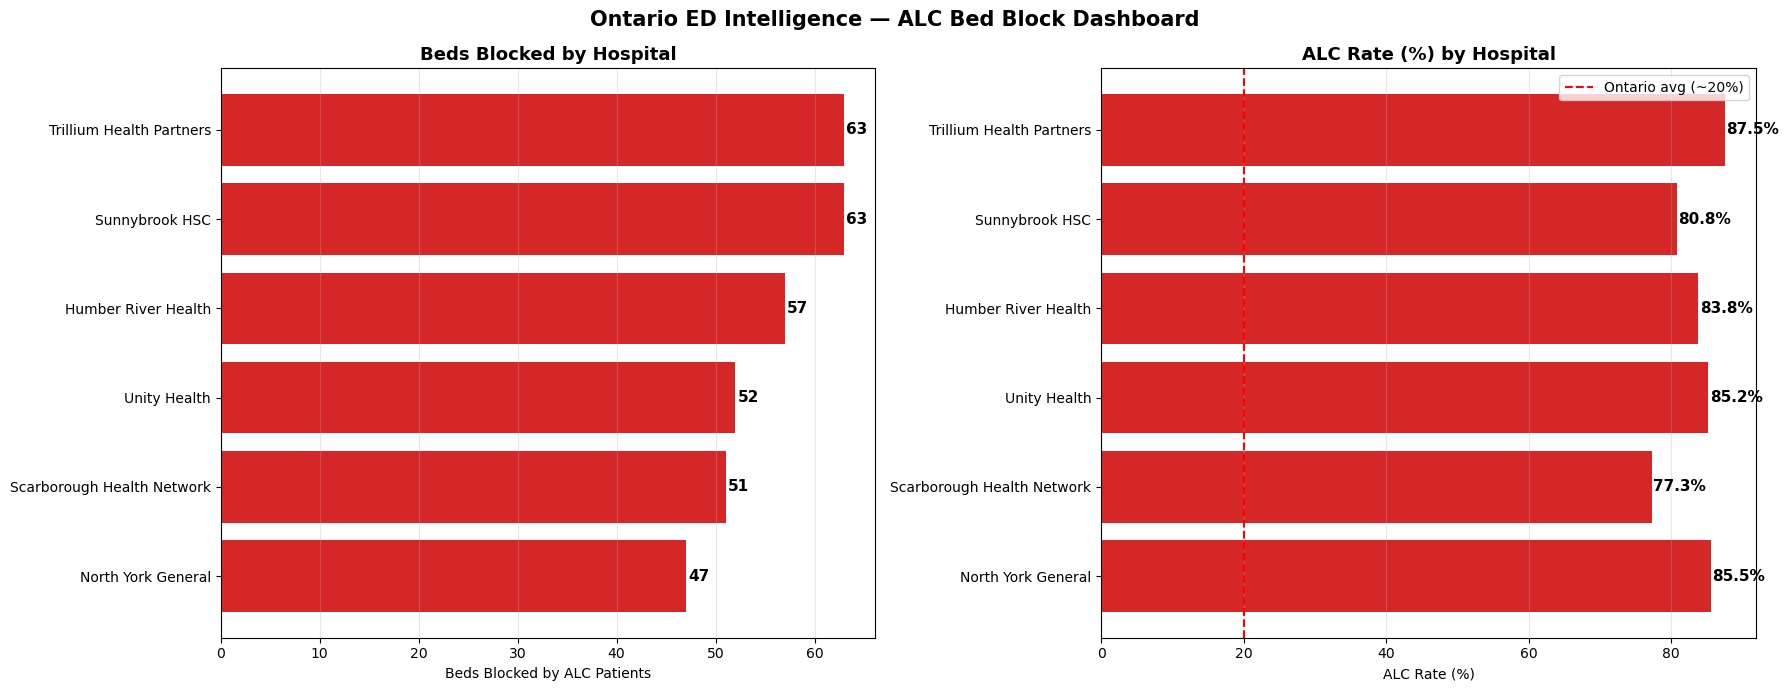

✅ Saved → reports/alc_beds_blocked_dashboard.png


In [7]:
df_model['alc_risk_score'] = model.predict_proba(X)[:, 1]
df_model['alc_predicted']  = (df_model['alc_risk_score'] > 0.5).astype(int)

current_admissions = df_model.sample(400, random_state=42).copy()

beds_blocked = current_admissions.groupby('hospital').agg(
    total_patients=('alc_predicted', 'count'),
    alc_patients=('alc_predicted', 'sum')
).reset_index()
beds_blocked['alc_rate_pct'] = (beds_blocked['alc_patients'] /
                                  beds_blocked['total_patients'] * 100).round(1)
beds_blocked = beds_blocked.sort_values('alc_patients', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

colours = ['#d62728' if v > 15 else '#ff7f0e' if v > 10 else '#2ca02c'
            for v in beds_blocked['alc_patients']]

bars = axes[0].barh(beds_blocked['hospital'], beds_blocked['alc_patients'], color=colours)
axes[0].set_xlabel('Beds Blocked by ALC Patients')
axes[0].set_title('Beds Blocked by Hospital', fontsize=13, fontweight='bold')
for bar, val in zip(bars, beds_blocked['alc_patients']):
    axes[0].text(val + 0.2, bar.get_y() + bar.get_height()/2,
                  str(val), va='center', fontweight='bold', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='x')

bars2 = axes[1].barh(beds_blocked['hospital'], beds_blocked['alc_rate_pct'], color=colours)
axes[1].set_xlabel('ALC Rate (%)')
axes[1].set_title('ALC Rate (%) by Hospital', fontsize=13, fontweight='bold')
axes[1].axvline(x=20, color='red', linestyle='--', linewidth=1.5, label='Ontario avg (~20%)')
axes[1].legend()
for bar, val in zip(bars2, beds_blocked['alc_rate_pct']):
    axes[1].text(val + 0.2, bar.get_y() + bar.get_height()/2,
                  f'{val}%', va='center', fontweight='bold', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Ontario ED Intelligence — ALC Bed Block Dashboard', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/alc_beds_blocked_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved → reports/alc_beds_blocked_dashboard.png')

## 7️⃣ Summary

In [8]:
top_features = sorted(
    zip(feature_names_display, np.abs(shap_values).mean(axis=0)),
    key=lambda x: x[1], reverse=True
)[:5]

print('=' * 60)
print('  ALC BED BLOCK ANALYZER — SUMMARY')
print('=' * 60)
print(f'  Patients analysed  : {len(df):,}')
print(f'  ALC rate           : {df.alc_flag.mean()*100:.1f}%')
print(f'  Model ROC-AUC      : {auc:.4f}')
print(f'  Avg Precision      : {ap:.4f}')
print()
print('  Top 5 ALC Risk Factors (SHAP):')
for i, (feat, val) in enumerate(top_features, 1):
    print(f'    {i}. {feat:<28} impact: {val:.4f}')
print()
print('  Beds Currently Blocked:')
for _, row in beds_blocked.sort_values('alc_patients', ascending=False).iterrows():
    print(f'    {row["hospital"]:<35} {row["alc_patients"]:>3} beds ({row["alc_rate_pct"]}%)')
print('=' * 60)
print()
print('📁 Outputs saved to reports/')
print('🚀 Next → Module 4: Prescription Anomaly Detector')

  ALC BED BLOCK ANALYZER — SUMMARY
  Patients analysed  : 8,000
  ALC rate           : 88.1%
  Model ROC-AUC      : 0.9840
  Avg Precision      : 0.9978

  Top 5 ALC Risk Factors (SHAP):
    1. Age                          impact: 2.6561
    2. Cognitive Impairment         impact: 1.4064
    3. Has Caregiver                impact: 0.9888
    4. Lives Alone                  impact: 0.8703
    5. Diagnosis                    impact: 0.7848

  Beds Currently Blocked:
    Sunnybrook HSC                       63 beds (80.8%)
    Trillium Health Partners             63 beds (87.5%)
    Humber River Health                  57 beds (83.8%)
    Unity Health                         52 beds (85.2%)
    Scarborough Health Network           51 beds (77.3%)
    North York General                   47 beds (85.5%)

📁 Outputs saved to reports/
🚀 Next → Module 4: Prescription Anomaly Detector
